One-dimensional Poisson model for the geomagnetic dipole moment
=====
***

The dipole field is generated by a series of delta function events. The recurrence time for the source events is governed by a Poisson process. The average recurrence time is fixed but the amplitude of the event is allowed to vary with a uniform distribution $U(a,b)$.  Negative (destructive) events are permitted by adopting a negative lower limit (a<0). The generation of the dipole field depends on the amplitude $A$ and the strength of the dipole field $x$.  In addition, a white noise source is added to the equations for $x$ to allow the field to reverse. We also need an additional white noise source to adjust the duration of transition fields. The imposed noise source has a zero mean and a variance $q_p$.

In [36]:
using Plots
using Distributions
using StatsBase
using DelimitedFiles
using DataFrames
using StatsPlots

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1662
┌ Warning: Module Plots with build ID 22150060139701 is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325
┌ Info: Skipping precompilation since __precompile__(false). Importing StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd].
└ @ Base loading.jl:1341


The event times are drawn from an expoential distribution with an average recurrence time

mean recurrence time = 0.002995154776819162 Myr


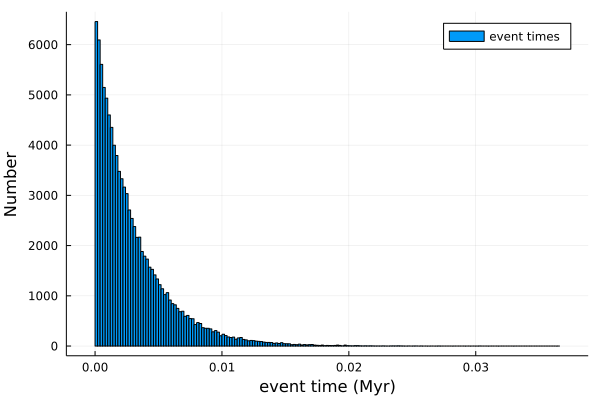

In [13]:
# evaluate event times
myr = 1.0e6;
recurrence = 3000/myr;         # average recurrence time (Myr)
nevents = 100000;
tevent = rand(Exponential(recurrence),nevents);  # Poisson event times
source = zeros(nevents);

# show distribution of event times
println("mean recurrence time = ",mean(tevent)," Myr")
histogram(tevent,label="event times",xlabel="event time (Myr)",ylabel="Number")

Model parameters. We adjust the values of $a$ and $b$ in the uniform distribution $U(a,b)$ to produce desired mean and variance of x(t))

In [14]:
# amplitude fluctuations
A = 5

amp_p = rand(Uniform(-0.4*A,5.9*A),nevents) # draw amplitude fluctuations from U(a,b)

# include random (white) noise
np = rand(Normal(),2*nevents);
qp = 180;       #  poloidal noise variance

# quenching magnitude
x0 = 4.7;         # defines onset of quenching; we chose a value slightly below the average <x>

We integrate the governing equations for the dipole field in two steps. The event interval is divided in half. Over the first half we have dipole decay and a white noise source. Over the second half we have dipole decay, white noise and a Poisson source event. The goal is to provide intermediate solutions for $x(t)$ between the source events. This helps when we interpolate the solution onto a uniform time spacing.

In [76]:
##Results
df = DataFrame(amplitude=Float16[], meanX=Float16[], stdX=Float16[], skewX=Float16[])


# amplitude fluctuations
A = 5
l=-0.4
u=5.9
amp_p = rand(Uniform(l*A,u*A),nevents) # draw amplitude fluctuations from U(a,b)

# include random (white) noise
np = rand(Normal(),2*nevents);
qp = 180;       #  poloidal noise variance

# quenching magnitude
x0 = 0.9*(l*A+u*A)/2;         # defines onset of quenching; we chose a value slightly below the average <x>
As = collect(0.1:1:100)
for A in As
    println(A)
    amp_p = rand(Uniform(-0.4*A,5.9*A),nevents) # draw amplitude fluctuations from U(a,b)
    
    # allocate memory for solution
    x = zeros(2*nevents);
    t = zeros(2*nevents);

    # set decay rate for dipole (here gamma = 1/tau_d, where tau_d is dipole decay time)
    gamma = 0.1 * 1000;

    # initial condition
    t[1] = 0.0;
    x[1] = 5.0;
    j = 2;

    # integrate over the number of source events
    for i = j : nevents

        # relax half a time step 
        dt = tevent[i]/2.0;
        t[j] = t[j-1] + dt;
        gp = exp(-x[j-1]^2/2.2^2);
        x[j] = x[j-1] * exp(-gamma * dt) + np[j]*sqrt(gp*qp*dt);;

        # relax rest of time step
        j += 1;
        t[j] = t[j-1] + dt;
        x[j] = x[j-1] * exp(-gamma * dt)

        # evaluate quenching
        fp = 1.0/ (1.0 + (x[j]/x0)^2);

        # add event and random noise
         gp = exp(-x[j]^2/2.2^2)
        x[j] += amp_p[i] * x[j] * fp + np[j]*sqrt(gp*qp*dt); 
        source[i] = amp_p[i] * x[j] * fp + np[j]*sqrt(gp*qp*dt);
        j+= 1;

    end

    # fill last entry
    t[end] = t[end-1] + tevent[end]/2.0
    x[end] = x[end-1]
    println("mean x = ",mean(abs.(x))," std x = ",std(abs.(x))," skewness = ",skewness(abs.(x)))
    
    meanX = mean(abs.(x))
    stdX = std(abs.(x))
    skewX = skewness(abs.(x))
    push!(df, (A,meanX, stdX, skewX))
end

println(df)

0.1
mean x = 2.2329219659822526 std x = 1.911639744327413 skewness = 1.9114330152339682
1.1
mean x = 46.834843618264145 std x = 13.77577894166669 skewness = -0.18211608051038553
2.1
mean x = 67.74095085853499 std x = 18.779640659726137 skewness = -0.23384964566062486
3.1
mean x = 83.59890117385203 std x = 22.938945874107336 skewness = -0.25409934721519595
4.1
mean x = 97.11839649926398 std x = 26.371496519856084 skewness = -0.26137550508146845
5.1
mean x = 108.92121449378054 std x = 29.478070454280168 skewness = -0.2515903464330102
6.1
mean x = 119.71729159243506 std x = 32.39192177186601 skewness = -0.2289806068913602
7.1
mean x = 129.5467951196527 std x = 35.22361461740377 skewness = -0.21936937709988721
8.1
mean x = 138.8326734010657 std x = 37.782014531420735 skewness = -0.2042248297176528
9.1
mean x = 147.3482993083333 std x = 39.96663548534484 skewness = -0.19356821871116037
10.1
mean x = 155.7713054316811 std x = 42.33741214734675 skewness = -0.17082632672557507
11.1
mean x = 16

mean x = 477.2894813048585 std x = 138.62046969325962 skewness = 1.0963091194066104
93.1
mean x = 481.81377141282394 std x = 139.7768763798981 skewness = 1.0602204567955342
94.1
mean x = 483.43788639890164 std x = 139.86750740416386 skewness = 0.8364772338635671
95.1
mean x = 487.24899204078486 std x = 145.7393567347319 skewness = 1.4733046680352722
96.1
mean x = 487.6686607897548 std x = 142.039221064757 skewness = 1.173645770169916
97.1
mean x = 491.02944051757476 std x = 144.77554222063662 skewness = 1.2538890406137875
98.1
mean x = 493.31572810084225 std x = 144.8117419321377 skewness = 1.1945477954010901
99.1
mean x = 497.2105191557818 std x = 149.58618238114673 skewness = 1.782427601574542
100×4 DataFrame
 Row │ amplitude  meanX    stdX     skewX     
     │ Float16    Float16  Float16  Float16   
─────┼────────────────────────────────────────
   1 │       0.1    2.232    1.912   1.911
   2 │       1.1   46.84    13.77   -0.1821
   3 │       2.1   67.75    18.78   -0.2339
   4 │ 

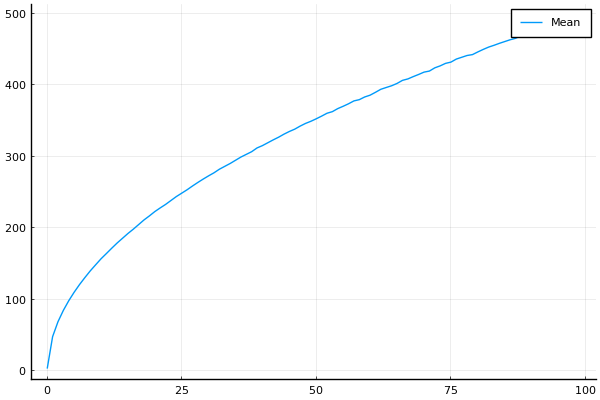

In [77]:
#plot relationships
pyplot()
@df df plot(:amplitude, :meanX, label ="Mean" )

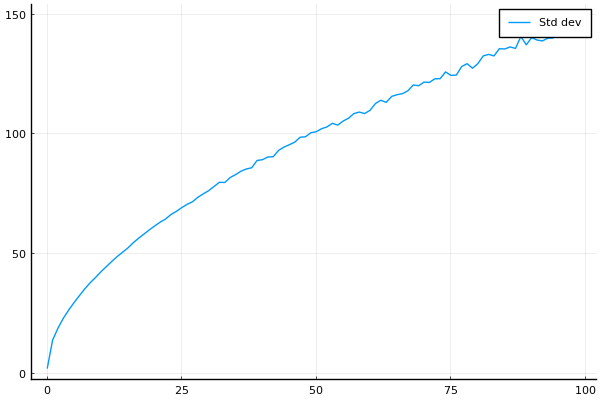

In [81]:
@df df plot(:amplitude, :stdX, linestyle = :solid, label ="Std dev" )


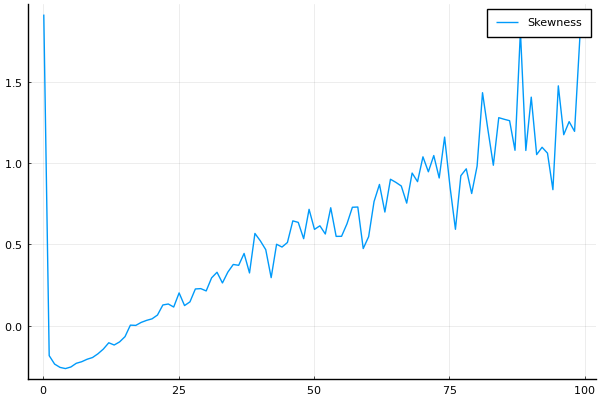

In [79]:
@df df plot(:amplitude, :skewX, linestyle = :solid, label ="Skewness" )

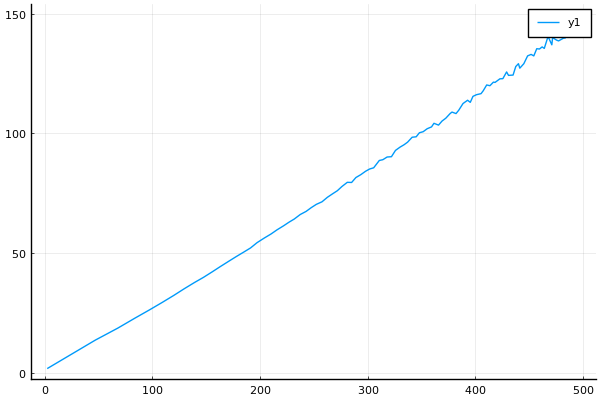

In [80]:
@df df plot(:meanX, :stdX, linestyle = :solid )

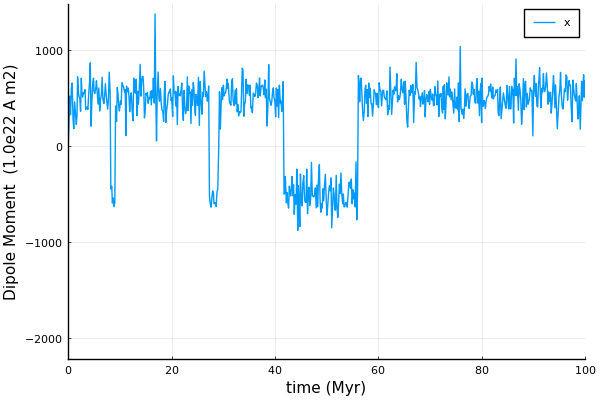

In [83]:
# print time series 
idecimate = 100;
plot(t[1:idecimate:end],(x[1:idecimate:end]),
    label="x",xlabel="time (Myr)",
    ylabel="Dipole Moment  (1.0e22 A m2)",
    xlim=(0,100))

In [84]:
savefig("TimeSeries_Poisson3000.pdf")

In [85]:
# save to file
save_file = true
      
if save_file
    open("dipole_3000.txt","w")  do io
        writedlm(io,[t x])
    end
end

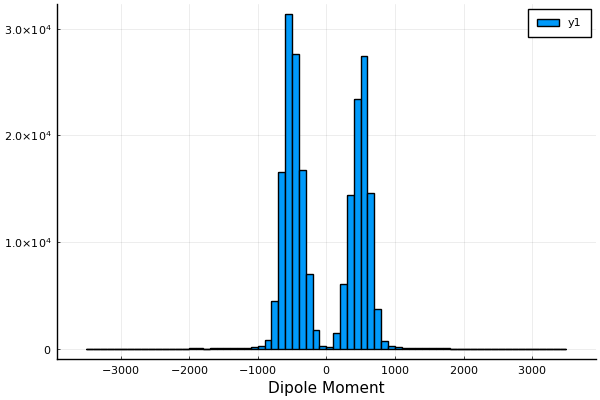

In [86]:
h = fit(Histogram,x,nbins=100)
plot(h,xlabel="Dipole Moment")

Fold the dipole moment with negative values to postive values

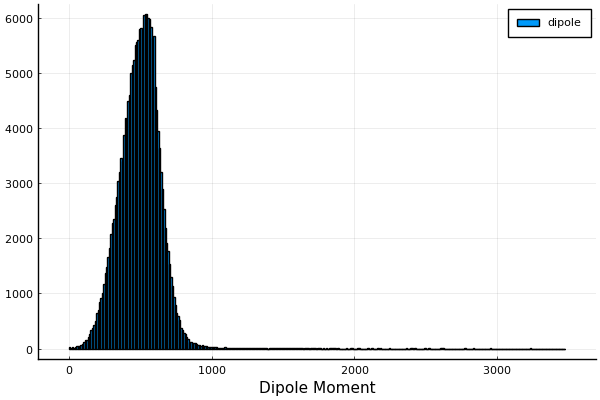

In [87]:
p1=histogram(abs.(x),xlabel="Dipole Moment",label="dipole")
plot(p1)

Evaluates the mean amplitudes $<A>$ and $<A^2>$, which appear in the definition of the drift $D_1$ and diffusion  $D_2$ terms.

In [10]:
function amplitudes(Ax,rate)
#
# evaluates the mean amplitudes <A>, <A2>, <A3.
# for poloidal and toroidal events
#
# input
# Ax, Ay - nominal amplitude of x and y events
# rate -  dimensionless rate of Poisson process

# output
# Ap, At  - mean amplitudes e.g. Ap[1,2,3]

# maximum and minimum amplitudes
Apmin = -0.4 * Ax;    # need to match the amplitude limits in U(a,b) from above
Apmax = 5.9 * Ax;



Ap = zeros(3);

Ap[1] = rate*(Apmin+Apmax)/2.0;
Ap[2] = rate*(Apmax^2 + Apmin^2 + Apmax*Apmin)/3.0;
Ap[3] = rate*(Apmax + Apmin)*(Apmax^2+Apmin^2)/4.0;



return Ap

end


amplitudes (generic function with 1 method)

507.437319046198


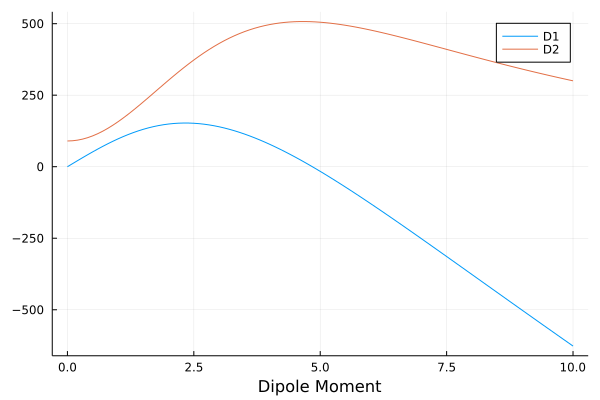

In [11]:
# compute drift and diffusion terms
rate = 1/recurrence
xbar = mean(abs.(x));
Ap = amplitudes(A,rate)


xplot = (0 : 0.1 : 10.0);
D1 = zeros(length(xplot))
D2 = zeros(length(xplot))
v = zeros(length(xplot))

for i = 1 : length(xplot)
    f = 1.0 / (1.0 + (xplot[i]/x0)^2);
    g = exp(-xplot[i]^2/2.2^2)
    D1[i] = -gamma*xplot[i] + Ap[1]*xplot[i]*f;
    D2[i] = 0.5*Ap[2]*(xplot[i]^2)*(f^2) + 0.5 * qp*g;
   # D3[i] = (1/6.0) * Ap[3]*(xplot[i]^2)*(f^3);
end

println(maximum(D2))
plot(xplot,D1,xlabel="Dipole Moment", label = "D1")
plot!(xplot,D2,label = "D2")


The histogram shows a noise source with $<dS> =0$, but it deviates significantly from $N(0,dt)$.

In [12]:
savefig("Drift&Diffusion.pdf")